# PROJETO 2 DE CIÊNCIA DOS DADOS

Integrantes: Amanda Colucci, Gustavo Borges, João Pedro Oliveira, Sophia Braz

Prof. Fabio Ayres e Maciel Vidal

Truma A - 2° semestre

### Importando as bibliotecas:

In [111]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import tree
import nltk
import re
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
from sklearn.metrics import confusion_matrix

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Encontrando o arquivo:

In [112]:
file = 'Dataset-Kickstarter-projects-2018.csv'
if file in os.listdir():
    print(f'Encontramos o arquivo {file}, podemos prosseguir!')
else:
    print(f'Não encontramos o arquivo {file} no diretório {os.getcwd()}!')

Encontramos o arquivo Dataset-Kickstarter-projects-2018.csv, podemos prosseguir!


### Lendo o arquivo csv: 

In [113]:
dataset = pd.read_csv(file)
dataset.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [114]:
# Vendo os tipos de variáveis do dataset
dataset.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

### Mudando as variáveis do dataset

In [115]:
dataset['main_category'] = dataset.loc[:,'main_category'].astype('category')
dataset['currency'] = dataset.loc[:,'currency'].astype('category')
dataset['deadline'] = dataset.loc[:,'deadline'].astype('datetime64')
dataset['launched'] = dataset.loc[:,'launched'].astype('datetime64')
#dataset['state'] = dataset.loc[:,'state'].astype('category')
dataset['country'] = dataset.loc[:,'country'].astype('category')

dataset.dtypes

ID                           int64
name                        object
category                    object
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Fazendo o delta_time e dropando as colunas que não vamos analisar

In [116]:
dataset['launched_Dates'] = pd.to_datetime(dataset['launched']).dt.date

dataset['launched_Year'] = pd.to_datetime(dataset['launched']).dt.year

dataset['launched_Month'] = pd.to_datetime(dataset['launched']).dt.month

dataset['deadline'] = pd.to_datetime(dataset['deadline']).dt.date

dataset['delta_time'] = dataset['deadline'] - dataset['launched_Dates']
dataset['delta_time'] = dataset['delta_time'].dt.days

dataset = dataset.drop(columns = ['ID', 'name', 'currency', 'pledged', 'usd pledged', 'category', 'launched', 'deadline', 'backers', 'launched_Dates', 'goal'])


In [117]:
# filtrando a coluna state
filtra_sucesso = dataset['state'] == 'successful'
filtra_falha = dataset['state'] == 'failed'
dataset = dataset.loc[(filtra_sucesso | filtra_falha ),:]
dataset

,main_category,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,Publishing,failed,GB,0.0,1533.95,2015,8,59
1,Film & Video,failed,US,2421.0,30000.00,2017,9,60
2,Film & Video,failed,US,220.0,45000.00,2013,1,45
3,Music,failed,US,1.0,5000.00,2012,3,30
5,Food,successful,US,52375.0,50000.00,2016,2,35
...,...,...,...,...,...,...,...,...
378654,Food,failed,US,154.0,6500.00,2017,3,30
378657,Film & Video,failed,US,155.0,1500.00,2011,6,27
378658,Film & Video,failed,US,20.0,15000.00,2010,7,46
378659,Technology,failed,US,200.0,15000.00,2016,1,31


In [118]:
dataset.dtypes


main_category       category
state                 object
country             category
usd_pledged_real     float64
usd_goal_real        float64
launched_Year          int64
launched_Month         int64
delta_time             int64
dtype: object

In [119]:
dataset['launched_Year'] = dataset.loc[:,'launched_Year'].astype('category')

### Análise Exploratória do DataSet

In [120]:
dataset.state.value_counts(normalize = True)

failed        0.596123
successful    0.403877
Name: state, dtype: float64

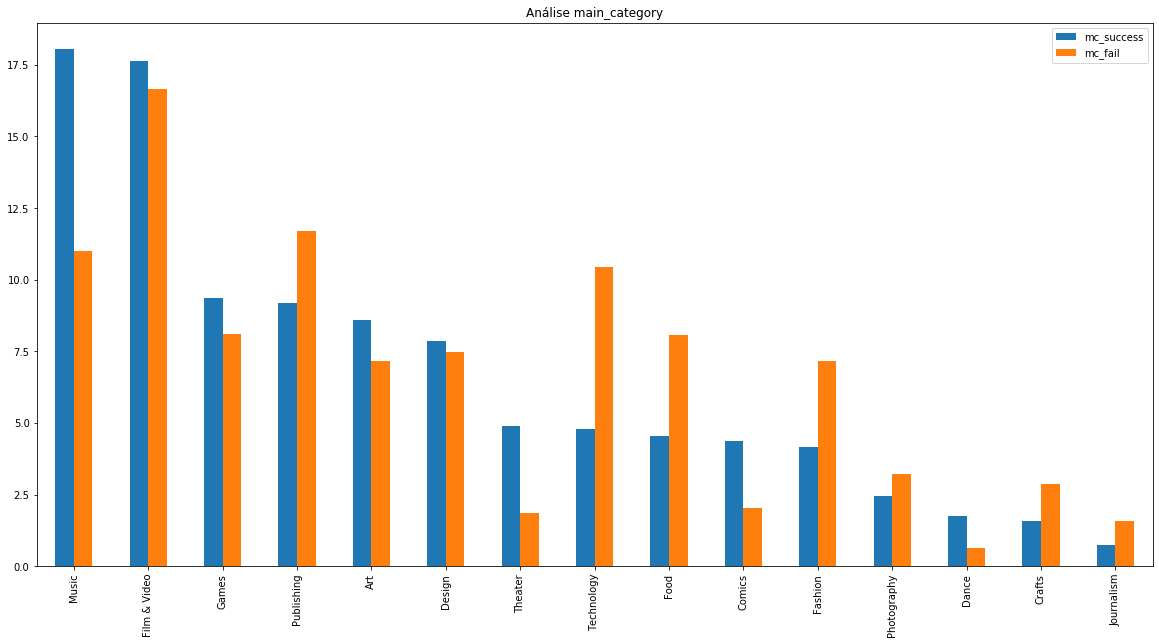

In [121]:
mc = pd.DataFrame()
mc['mc_success'] = dataset.loc[filtra_sucesso,'main_category'].value_counts(normalize = 'index')*100
mc['mc_fail'] = dataset.loc[filtra_falha,'main_category'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mc = mc.plot.bar(ax = ax1, title = 'Análise main_category')

In [122]:
verificacao = pd.crosstab(dataset.main_category, dataset.state, normalize = 'index', margins = True)*100 

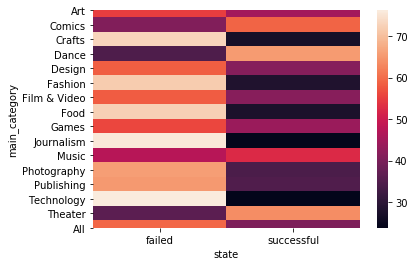

In [123]:
sns.heatmap(verificacao)

A partir dos gráficos acima, é possível ver que do total de categorias, mais da metade obtiveram sucesso, sendo a categoria com maior taxa de sucesso a de musica, e a de menor sucesso a de jornalismo. Já a de falha, sendo minoria, a categoria com maior taxa é a de filme e video, e a de menos é a de dança. Também é possível observar que nas categorias de Fotografia, Filme e Vídeo, Jogos e Design as taxas de sucesso e falha tem um valor muito próximo, indicando uma certa incerteza nesses resultados.

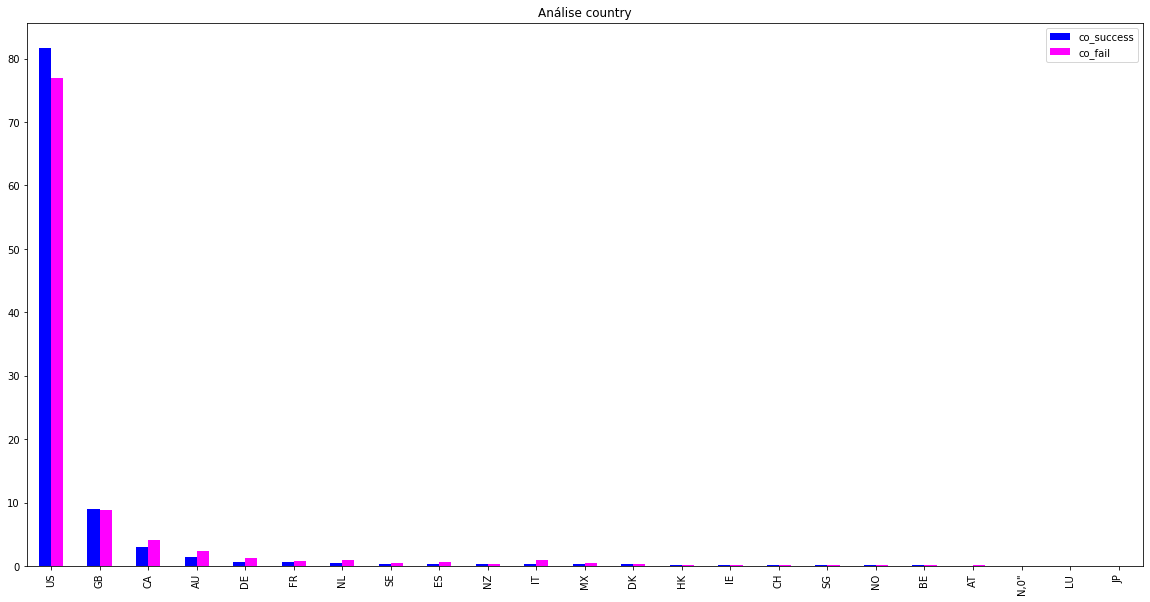

In [124]:
co = pd.DataFrame()
co['co_success'] = dataset.loc[filtra_sucesso,'country'].value_counts(normalize = 'index')*100
co['co_fail'] = dataset.loc[filtra_falha,'country'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_co = co.plot.bar(ax = ax1, title = 'Análise country', color = ['blue', 'magenta'])

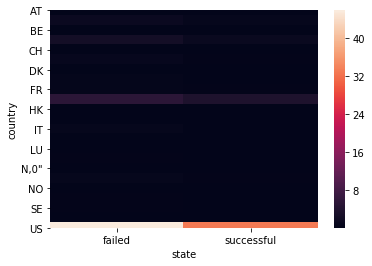

In [125]:
verificacao = pd.crosstab(dataset.country, dataset.state, normalize = True)*100
sns.heatmap(verificacao)

Levando em consideração os países em que ocorrem as campanhas de financiamento coletivo, fica clara uma enorme diferença entre o número de campanhas feitas nos Estados Unidos e nos países restantes. Esse fato pode prejudicar nossa análise, já que os números dos Estados Unidos são extremamente grandes e os da maioria dos países são extremamente pequenos.   

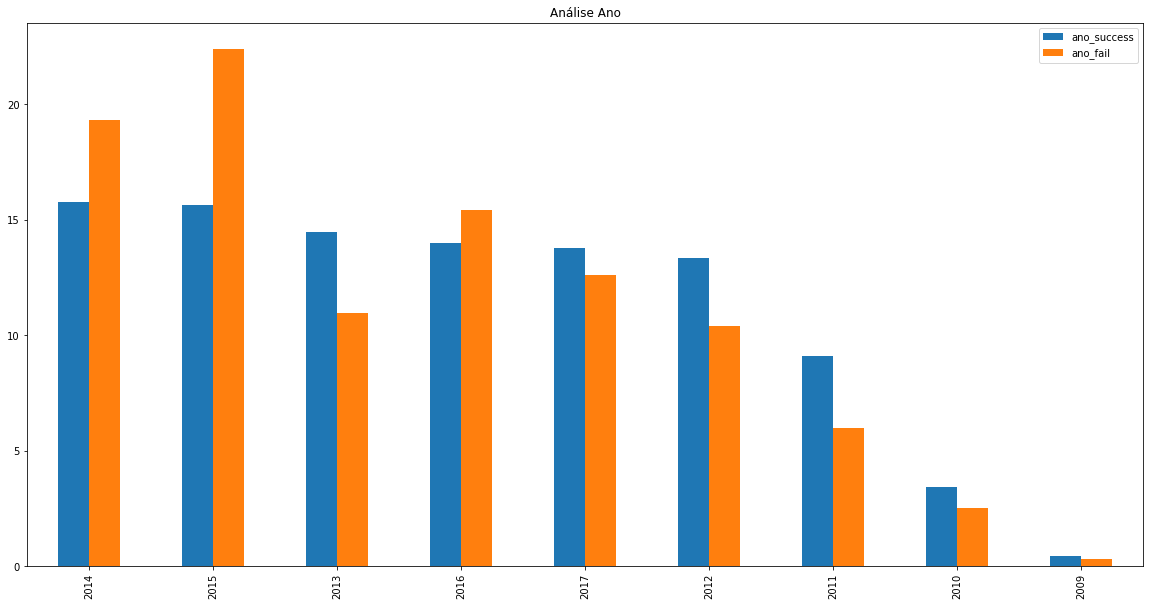

In [126]:
ano = pd.DataFrame()
ano['ano_success'] = dataset.loc[filtra_sucesso,'launched_Year'].value_counts(normalize = 'index')*100
ano['ano_fail'] = dataset.loc[filtra_falha,'launched_Year'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_ano = ano.plot.bar(ax = ax1, title = 'Análise Ano')

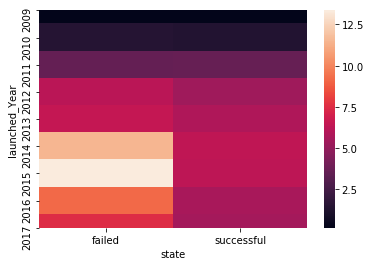

In [127]:
verificacao = pd.crosstab(dataset.launched_Year, dataset.state, normalize = True)*100
sns.heatmap(verificacao)

Com essa análise podemos ver que ao longo dos anos um maior crescimento de lançamentos, com destaque nos anos de 2014 e 2015. Porém temos que levar em consideração também que nesses anos o ínidce de falha foi muito maior do que nos outros anos. No último ano analisado (2017), a taxa de sucesso ultrapassa a de falha. 

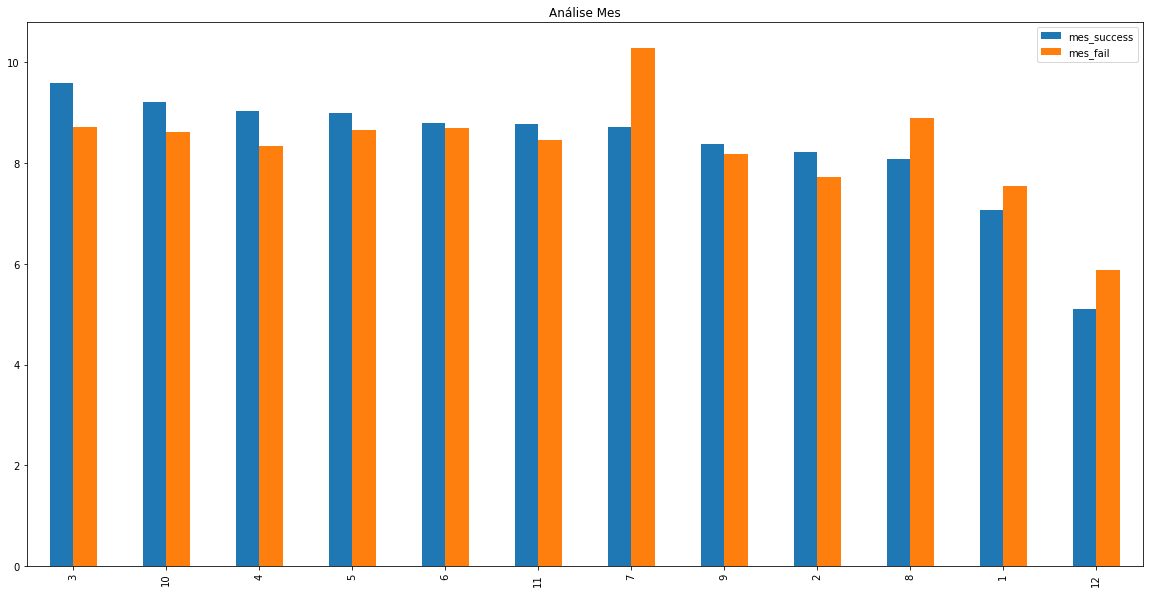

In [128]:
mes = pd.DataFrame()
mes['mes_success'] = dataset.loc[filtra_sucesso,'launched_Month'].value_counts(normalize = 'index')*100
mes['mes_fail'] = dataset.loc[filtra_falha,'launched_Month'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mes = mes.plot.bar(ax = ax1, title = 'Análise Mes')

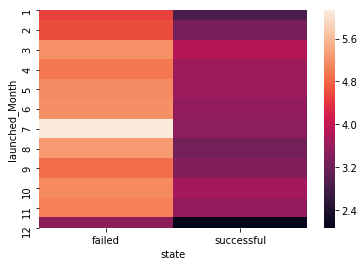

In [129]:
verificacao = pd.crosstab(dataset.launched_Month, dataset.state, normalize = True)*100
sns.heatmap(verificacao)

Partindo para a análise dos meses, a primeira coisa a se notar é que os projetos que são lançados em Julho tem uma taxa de fracasso muito maior do que a dos outros meses. Nos meses de Janeiro e Dezembro, ambas as taxas são menores em comparação com os outros meses, e a taxa de fracasso costuma ser maior, o que pode se relacionar com a época festiva deste meses. 

#### Associando variáveis qualitativas com quantitativas

In [130]:
a = dataset.groupby(['state']).describe()
a.dropna(inplace = True)
a.transpose()
a

usd_pledged_real                                              \
                      count          mean            std   min      25%   
state                                                                     
failed             197719.0   1320.603817    6820.249351  0.00     2.64   
successful         133956.0  22670.795231  151090.323352  0.79  2000.00   

                                            usd_goal_real                ...  \
                50%        75%          max         count          mean  ...   
state                                                                    ...   
failed       100.00    663.000    757352.94      197719.0  63174.742222  ...   
successful  5107.25  13232.075  20338986.27      133956.0   9532.853357  ...   

           launched_Month       delta_time                                   \
                      75%   max      count       mean        std  min   25%   
state                                                                         
failed                9.0  12.0   197719.0  35.173322  13.175105  1.0  30.0   
successful            9.0  12.0   133956.0  32.156447  11.771125  1.0  30.0   

                              
             50%   75%   max  
state                         
failed      30.0  40.0  92.0  
successful  30.0  34.0  92.0  

[2 rows x 32 columns]

In [131]:
goal_success = dataset.loc[filtra_sucesso,'usd_goal_real']
goal_falha = dataset.loc[filtra_falha,'usd_goal_real']
pledged_success = dataset.loc[filtra_sucesso,'usd_pledged_real']
pledged_falha = dataset.loc[filtra_falha,'usd_pledged_real']
pledged_falha

0            0.0
1         2421.0
2          220.0
3            1.0
7          453.0
           ...  
378654     154.0
378657     155.0
378658      20.0
378659     200.0
378660     524.0
Name: usd_pledged_real, Length: 197719, dtype: float64

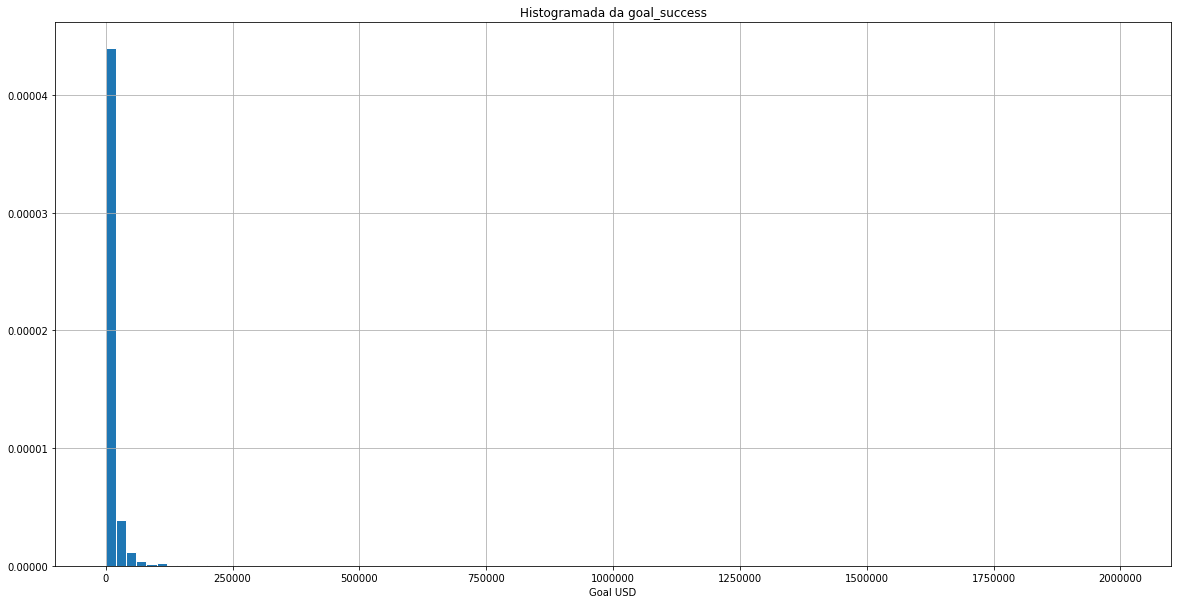

In [132]:
faixa_sucesso = np.arange(0,2.01561e+06,20000)

fig = plt.figure(figsize=(20, 10))
plt.hist(goal_success, bins = faixa_sucesso, edgecolor='white',density=True)
plt.title('Histogramada da goal_success')
plt.xlabel('Goal USD')
plt.ylabel('')
plt.grid()
plt.show()

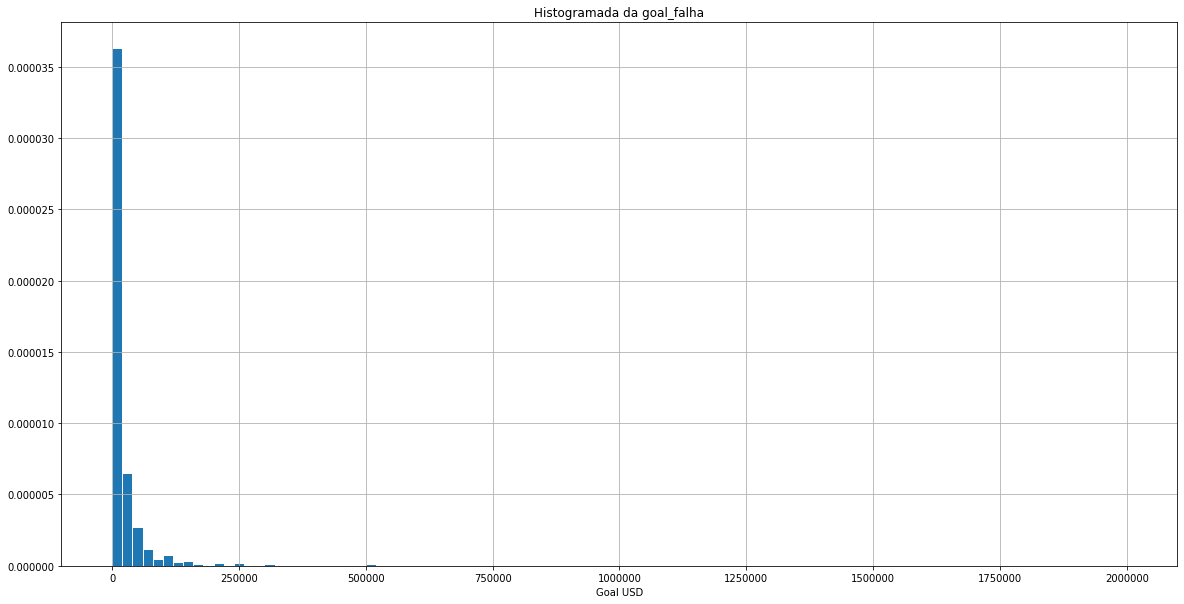

In [133]:
faixa_falha = np.arange(0,1.66361e+08,5000)

fig = plt.figure(figsize=(20, 10))
plt.hist(goal_falha, bins = faixa_sucesso, edgecolor='white', density = True)
plt.title('Histogramada da goal_falha')
plt.xlabel('Goal USD')
plt.ylabel('')
plt.grid()
plt.show()

Nesses dois histogramas acima, os objetivos de arrecadação final foram analisados. É possível notar que, quando o objetivo tem um valor muito baixo, a taxa de sucesso é maior que a taxa de falha. Também é possível notar que à medida que o valor do objetivo final aumenta, a taxa de falha supera o valor da taxa de sucesso. 

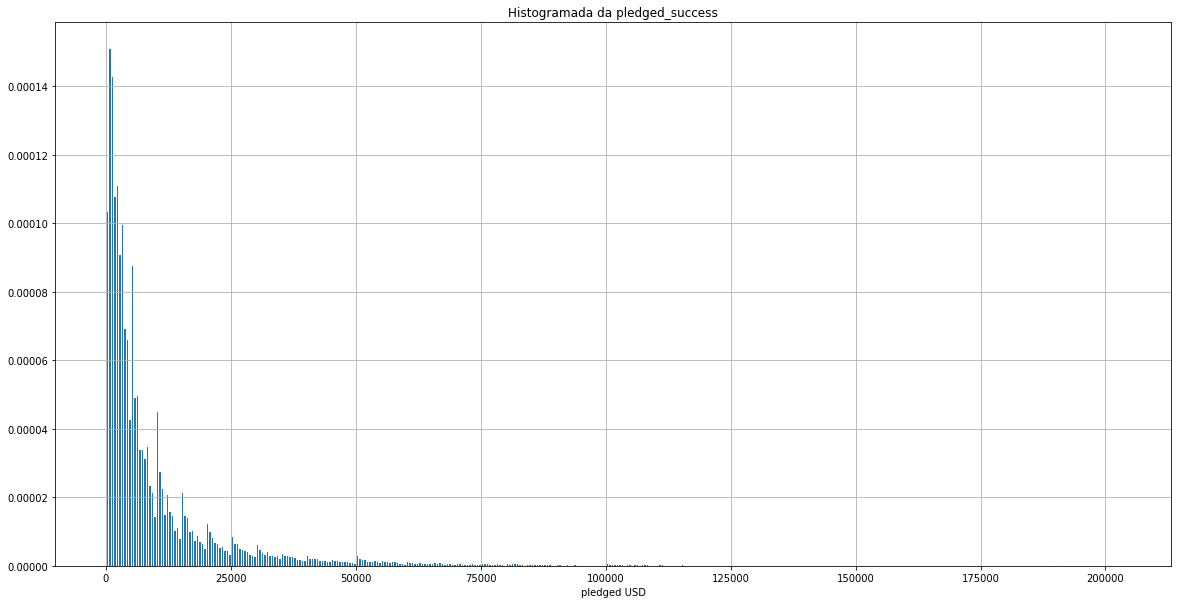

In [134]:
faixa_success_pledged = np.arange(0,2.0339e+05,500)

fig = plt.figure(figsize=(20, 10))
plt.hist(pledged_success, bins = faixa_success_pledged, edgecolor='white',density=True)
plt.title('Histogramada da pledged_success')
plt.xlabel('pledged USD')
plt.ylabel('')
plt.grid()
plt.show()

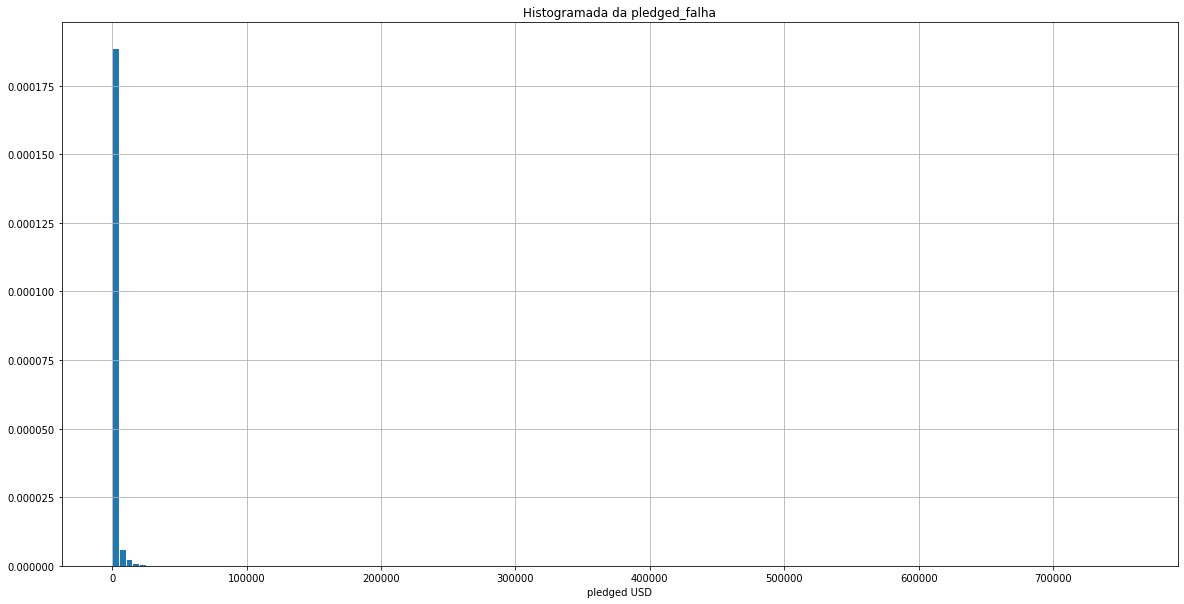

In [135]:
faixa_falha_pledged = np.arange(0,757353,5000)

fig = plt.figure(figsize=(20, 10))
plt.hist(pledged_falha, bins = faixa_falha_pledged, edgecolor='white',density=True)
plt.title('Histogramada da pledged_falha')
plt.xlabel('pledged USD')
plt.ylabel('')
plt.grid()
plt.show()

Ao analisar esses dois histogramas, é possível notar que quanto mais próximo de 0 é o valor prometido para o financiamento do projeto, maior é a taxa de falha. Além disso, podemos observar que quando esse valor aumenta, as  taxas de sucesso também aumentam e, em certo ponto, chegam a ultrapassar as taxas de falha.

In [136]:
dataset

,main_category,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,Publishing,failed,GB,0.0,1533.95,2015,8,59
1,Film & Video,failed,US,2421.0,30000.00,2017,9,60
2,Film & Video,failed,US,220.0,45000.00,2013,1,45
3,Music,failed,US,1.0,5000.00,2012,3,30
5,Food,successful,US,52375.0,50000.00,2016,2,35
...,...,...,...,...,...,...,...,...
378654,Food,failed,US,154.0,6500.00,2017,3,30
378657,Film & Video,failed,US,155.0,1500.00,2011,6,27
378658,Film & Video,failed,US,20.0,15000.00,2010,7,46
378659,Technology,failed,US,200.0,15000.00,2016,1,31


In [137]:
dataset['state'] = dataset.state.map({'successful': 0,'failed': 1})

dataset

,main_category,state,country,usd_pledged_real,usd_goal_real,launched_Year,launched_Month,delta_time
0,Publishing,1,GB,0.0,1533.95,2015,8,59
1,Film & Video,1,US,2421.0,30000.00,2017,9,60
2,Film & Video,1,US,220.0,45000.00,2013,1,45
3,Music,1,US,1.0,5000.00,2012,3,30
5,Food,0,US,52375.0,50000.00,2016,2,35
...,...,...,...,...,...,...,...,...
378654,Food,1,US,154.0,6500.00,2017,3,30
378657,Film & Video,1,US,155.0,1500.00,2011,6,27
378658,Film & Video,1,US,20.0,15000.00,2010,7,46
378659,Technology,1,US,200.0,15000.00,2016,1,31


In [138]:
for col in dataset.dtypes[dataset.dtypes == "category"].index:
    for_dummy = dataset.pop(col)
    dataset = pd.concat([dataset,pd.get_dummies(for_dummy,prefix=col)],axis=1)
dataset

,state,usd_pledged_real,usd_goal_real,launched_Month,delta_time,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,country_US,launched_Year_2009,launched_Year_2010,launched_Year_2011,launched_Year_2012,launched_Year_2013,launched_Year_2014,launched_Year_2015,launched_Year_2016,launched_Year_2017
0,1,0.0,1533.95,8,59,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,2421.0,30000.00,9,60,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1,220.0,45000.00,1,45,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,1,1.0,5000.00,3,30,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5,0,52375.0,50000.00,2,35,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,1,154.0,6500.00,3,30,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
378657,1,155.0,1500.00,6,27,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
378658,1,20.0,15000.00,7,46,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
378659,1,200.0,15000.00,1,31,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [139]:
labels = dataset.pop('state')
dataset

,usd_pledged_real,usd_goal_real,launched_Month,delta_time,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_US,launched_Year_2009,launched_Year_2010,launched_Year_2011,launched_Year_2012,launched_Year_2013,launched_Year_2014,launched_Year_2015,launched_Year_2016,launched_Year_2017
0,0.0,1533.95,8,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2421.0,30000.00,9,60,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,220.0,45000.00,1,45,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,1.0,5000.00,3,30,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5,52375.0,50000.00,2,35,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,154.0,6500.00,3,30,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
378657,155.0,1500.00,6,27,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
378658,20.0,15000.00,7,46,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
378659,200.0,15000.00,1,31,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [140]:
x_train,x_test,y_train,y_test = train_test_split(dataset, labels,test_size=0.25)

In [141]:
features = x_train.columns

### random forest

In [142]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

C:\Users\amand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [143]:
y_pred = rf.predict(x_test)

In [144]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate,true_possitive_rate)
roc_auc

0.991341945407388

In [145]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[33354   124]
 [  673 48768]]


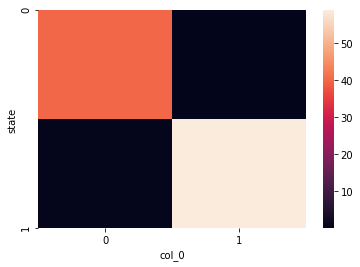

In [146]:
verificacao = pd.crosstab(y_test, y_pred, normalize = True)*100
sns.heatmap(verificacao)

### iterando o programa:

In [147]:
x_train = x_train.drop(columns = ['usd_pledged_real'])
x_test = x_test.drop(columns = ['usd_pledged_real'])
x_train

,usd_goal_real,launched_Month,delta_time,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_US,launched_Year_2009,launched_Year_2010,launched_Year_2011,launched_Year_2012,launched_Year_2013,launched_Year_2014,launched_Year_2015,launched_Year_2016,launched_Year_2017
158928,2700.00,4,21,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
199925,1136.30,3,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
245323,4000.00,1,42,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
171763,7500.00,8,30,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
68369,2000.00,10,60,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34923,1679.04,8,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
257427,300.00,12,35,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
357124,10000.00,7,30,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
257171,1000.00,11,24,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [148]:
rf_2 = RandomForestClassifier()
rf_2.fit(x_train,y_train)

C:\Users\amand\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [149]:
y_pred_2 = rf_2.predict(x_test)

In [150]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_pred_2)
roc_auc_2 = auc(false_positive_rate,true_possitive_rate)
roc_auc_2

0.6053575285691281

In [151]:
confusion_matrix = confusion_matrix(y_test, y_pred_2)
print(confusion_matrix)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
verificacao = pd.crosstab(y_test, y_pred_2, normalize = True)*100
sns.heatmap(verificacao)

In [ ]:
n_estimators = [1,2,4,8,32,64,100,200]

train_results = []
test_results = []

for estimators in n_estimators:
    RF = RandomForestClassifier(n_estimators=estimators, n_jobs=-1)
    RF.fit(x_train,y_train)
    train_pred = RF.predict(x_train)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_train,train_pred)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    train_results.append(roc_auc)
    y_predict = RF.predict(x_test)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_predict)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    test_results.append(roc_auc)
    
    

line1, = plt.plot(n_estimators, train_results, "b", label = "Train AUC")
line2, = plt.plot(n_estimators, test_results, "r",label = "Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Decision Tree: comparando metodos de análise

In [ ]:
dt = tree.DecisionTreeClassifier(max_leaf_nodes = 10,random_state = 0)
dt = dt.fit(x_train, y_train)

In [ ]:
y_prep_dt = dt.predict(x_train)

In [ ]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_train,y_prep_dt)
roc_auc_dt = auc(false_positive_rate,true_possitive_rate)
roc_auc_dt

In [ ]:
y_prep_dt = dt.predict(x_test)

In [ ]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_prep_dt)
roc_auc_dt = auc(false_positive_rate,true_possitive_rate)
roc_auc_dt

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred_dt)
print(confusion_matrix)

In [ ]:
verificacao = pd.crosstab(y_test, y_prep_dt, normalize = True)*100
sns.heatmap(verificacao)

In [ ]:
fig = plt.figure(figsize=(25,20))
grafico = tree.plot_tree(dt, feature_names= features,class_names=['successful','failed'],filled=True)

In [ ]:
n_leaf_nodes = [None,2,4,8,32,64,100,200]

train_results_dt = []
test_results_dt = []

for num_nodes in n_leaf_nodes:
    DT = tree.DecisionTreeClassifier(max_leaf_nodes = num_nodes ,random_state = 0)
    DT = DT.fit(x_train, y_train)
    train_pred = DT.predict(x_train)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_train,train_pred)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    train_results_dt.append(roc_auc)
    y_predict = DT.predict(x_test)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_predict)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    test_results_dt.append(roc_auc)
    
    

line1, = plt.plot(n_leaf_nodes, train_results_dt, "b", label = "Train AUC")
line2, = plt.plot(n_leaf_nodes, test_results_dt, "r",label = "Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Regressção Logistica

In [ ]:
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary2())

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

In [ ]:
y_pred_Lrg = logreg.predict(x_test)

In [ ]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_pred_Lrg)
roc_auc_dt = auc(false_positive_rate,true_possitive_rate)
roc_auc_dt

In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred_Lrg)
print(confusion_matrix)

In [ ]:
verificacao = pd.crosstab(y_test, y_pred_Lrg, normalize = True)*100
sns.heatmap(verificacao)